In [1]:
import numpy as np
from scipy import stats 
import pandas as pd
from tqdm import tqdm_notebook
import cdpm
import pandas_datareader as pd_reader
from sklearn.preprocessing import add_dummy_feature
import matplotlib as mpl
import random

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
num_draws = int(5e3)
include_mean = True
mode = '.tmp'
# mode = ''

In [4]:
## simulate data for VAR with t-distributed shock

In [5]:
time_dim = 3000;
Phi1 = np.array([[0.7, -0.2],[0.0, 0.9]])
Phi0 = np.array([0.2,0.1])
Sigma = np.array([[0.3,0.0],[0.2,0.3]])


state_dim = Phi1.shape[1]
#ydata_n = np.empty((time_dim, state_dim))
simdata = np.zeros((time_dim, state_dim))

In [6]:
Sigma.dot(Sigma.T)

array([[0.09, 0.06],
       [0.06, 0.13]])

In [7]:

random.seed(123)

simdata = np.empty((time_dim, state_dim))
simdata[0,:] = Phi0
# with normal distributed shock
for t in range(1, time_dim):
    simdata[t, :] = Phi0 +  Phi1.dot(simdata[t-1,:]-Phi0) + Sigma.dot(
        stats.multivariate_normal.rvs(cov=np.identity(state_dim)))

t_df = 5.7 # as in Brunnermeier, Palia, Sastry, Sims (2019)    
# with t distributed shock
#for t in range(1, time_dim):
#    simdata[t, :] = Phi0 + Phi1.dot(simdata[t-1,:]-Phi0) + Sigma.dot(np.random.standard_t(t_df, state_dim))

In [8]:
#data_fig, data_ax = mpl.pyplot.subplots(1,1)
#data_ax.plot(simdata)

In [9]:
#data_n_fig, data_n_ax = mpl.pyplot.subplots(1,1)
#data_n_ax.plot(ydata_n)

In [10]:
data = pd.DataFrame(simdata)
data.index = pd.date_range(start='1995', freq='W', periods=time_dim)
data = data.transform(stats.zscore).dropna() # standardize

In [11]:
data.plot()

In [12]:
#data.columns = ['Var1', 'Var2']

In [13]:
data.describe()

0             1
count  3.000000e+03  3.000000e+03
mean   9.473903e-18 -4.736952e-18
std    1.000167e+00  1.000167e+00
min   -3.259322e+00 -3.449347e+00
25%   -6.496651e-01 -6.761260e-01
50%    3.621634e-02 -2.914340e-02
75%    6.428152e-01  6.931124e-01
max    3.331611e+00  3.313677e+00

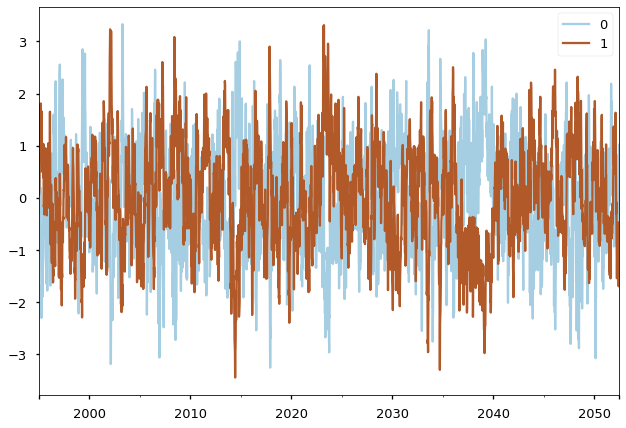

In [14]:
data.plot(colormap=mpl.cm.get_cmap('Paired'))

In [15]:
data

0         1
1995-01-01 -0.043035  0.062432
1995-01-08  0.071209  0.072806
1995-01-15 -0.114731  0.169246
1995-01-22  0.187170  0.484697
1995-01-29  0.546185  0.739225
...              ...       ...
2052-05-26  0.071198 -1.091891
2052-06-02 -1.094075 -1.698709
2052-06-09  0.472222 -1.122469
2052-06-16  1.025749 -0.823570
2052-06-23  0.985463 -0.475173

[3000 rows x 2 columns]

In [16]:
time_dim = data.shape[0]
regressor_dim = data.shape[1] + int(include_mean)
regressand_dim = data.shape[1]

In [17]:
stick_scale = 5
# mean and standard deviation
beta_mu = 0 * np.eye(regressor_dim,regressand_dim, k=-1)
beta_sigma = .25 * np.eye(regressor_dim, regressor_dim) 
beta_df = 5
comp_cov_mu1 = 3
comp_cov_mu2 = 3
# comp_std_mean = .25
# comp_cov_mean = comp_std_mean**2 * np.ones(regressand_dim)


In [18]:
beta = pd.DataFrame(beta_mu)
beta.columns=list(data.columns)
beta.index = ['Intercept'] + list(data.columns)

In [19]:
comp_cov_mean =  .5 * ( 1 - np.diag(beta.values, k=-1)) + .005

In [20]:
comp_cov_mean

array([0.505, 0.505])

In [50]:
beta_df

5

In [51]:
prior = {
    'coeff': {'mean':beta.values, 'cov': beta_sigma, 'hierarchical': True, 'nu': beta_df},
    'cov':  {'scale': comp_cov_mean, 'mu1': comp_cov_mu1, 'mu2': comp_cov_mu2, 'hierarchical': True},
    'expected_cluster_dim': stick_scale,
}

In [52]:
if include_mean:
    regressor =  pd.DataFrame(add_dummy_feature(data.iloc[:-1]), index=data.index[:-1],
                             columns=['Intercept'] + list(data.columns))
else:
    regressor = data.iloc[:-1]

regressand = data.iloc[1:]

In [53]:
filename = f'../results/varnorm_cdpm{mode}.hdf'

In [66]:
filename

'../results/varnorm_cdpm.tmp.hdf'

In [54]:
return_dict = cdpm.estimate_cdpm(regressor=regressor,regressand=regressand, num_draws=num_draws, 
                                 progress_bar=tqdm_notebook, prior=prior,filename=filename,
                                 data=data, clusters=2)

In [55]:
Phi1

array([[ 0.7, -0.2],
       [ 0. ,  0.9]])

In [64]:
np.nanmean(return_dict['beta'][:, 3, :, :], axis=0)

array([[ 0.10817908,  0.11021145],
       [ 0.59335413,  0.02503818],
       [-0.17757323,  0.82219085]])

In [57]:
var_filename = f'../results/varnorm_VAR{mode}.hdf'

In [65]:
var_filename

'../results/varnorm_VAR.tmp.hdf'

In [59]:
return_var_dict = cdpm.estimate_var(beta_mu=beta_mu, comp_cov=comp_cov_mean * np.eye(regressand_dim),
                                    regressor=regressor, regressand=regressand, num_draws=num_draws, 
                                    progress_bar=tqdm_notebook, prior=prior,filename=var_filename, data=data)

In [60]:
np.mean(return_var_dict['beta'], axis=0)

array([[ 2.74743722e-04, -2.23134989e-04],
       [ 6.93388854e-01, -1.57779035e-03],
       [-3.04748646e-01,  9.02050850e-01]])